In [351]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import seaborn as sns

import bayesflow as bf
import tensorflow as tf
from functools import partial
from IPython.display import HTML

# Amortized Posterior Estimation for Simple Agent-Based Model
**Vicsek Model in BayesFlow** 

In this notebook, we demonstrate amortized posterior estimation for a simple agent-based model (ABM). ABM is of interest because it is inherently hierarchical, but the interaction between agents does not always lead to tractable mathematical formulation. In addition, the resulting formulation can be either vague, involving little to no equations, or extremely complex, involving a large amount of parameters and equations, making meaningful inference difficult. 

Neural surrogates have proven to be one of the promising approaches for extracting model parameters for ABM. As an example, we use BayesFlow for the posterior estimation for a simple ABM: the [Vicsek model](https://en.wikipedia.org/wiki/Vicsek_model). The model, which characterizes the dynamic of collective motion, has found numerous applications from simulating active Brownian particles, from modeling social dynamics.

The model is formulated as follows:

\begin{align}
    \theta_{j, t} &= \langle \theta_{i, t}\rangle_{|r_j - r_i| < r} + \eta_{j,t-1}, \\
    \mathrm{d} \mathbf{x}_{j,t} &= v \mathrm{d}t
    \begin{bmatrix}
        \cos \theta_{j, t} \\
        \sin \theta_{j, t}
    \end{bmatrix},
\end{align}

where

* $\theta_{j, t}, \theta_{i, t}$ is the heading direction of agent $j$ and $i$ at a given time $t$. Here, $i$ is the neighboring agent of $j$ within a perception distance $r$;
* $\eta_{j, t-1} \sim \mathcal{U}(-\mu_j, \mu_j)$ is a rotational noise for agent $j$. In addition to uniform sampling, this noise can also be sampled from  Gaussian or von Mises distributions;
* $\mathbf{x}_{j, t}$ is the position of agent $j$ as a given time $t$; and
* $v$ is the speed of agent $j$.

For our priors, we are interested in 3 parameters: $r$, $v$, and $\eta$.

In [485]:
# Constants
NUM_AGENTS = 49     # Number of agents
TIME_STEPS = 200    # Number of time steps
BOUND_SIZE = 10     # Size of the square domain

# Parameter names
PARAM_NAMES = [
    r"$r_j$", 
    r"$v_j$", 
    r"$\eta$",
    r"$\alpha_j$", 
    r"$\beta_j$", 
    r"$\rho_j$",
    r"$\mu_j$"
]

### Simulator

In [297]:
def simulator_fun(
    theta : np.array = None,
    num_agents : int = 49, 
    radius : float = 1.0, 
    speed : float = 0.1, 
    eta : float = 1.0, 
    num_timesteps : int = 100, 
    boundary_size : float = 10.0, 
    rng=None
):

    if rng is None:
        rng = np.random.default_rng()

    if theta is not None:
        radius, speed, eta = theta[0], theta[1], theta[2]


    def initialize_agents(num_agents=num_agents):
        positions = rng.uniform(size=(num_agents, 2)) * boundary_size
        directions = rng.uniform(size=num_agents) * 2 * np.pi

        return positions, directions


    trajectories = np.zeros((num_timesteps + 1, num_agents, 2))
    headings = np.zeros((num_timesteps + 1, num_agents, 1))

    positions, directions = initialize_agents(num_agents)
    trajectories[0] = positions
    headings[0] = directions[:,np.newaxis]

    for t in range(num_timesteps):
        new_directions = np.zeros(num_agents)
        for i in range(num_agents):
            neighbors = []
            for j in range(num_agents):
                if i != j and np.linalg.norm(positions[i] - positions[j]) < radius:
                    neighbors.append(directions[j])
            if neighbors:
                avg_direction = np.arctan2(np.mean(np.sin(neighbors)), np.mean(np.cos(neighbors)))
                new_directions[i] = avg_direction + rng.uniform(-eta * 0.5, eta * 0.5)
            else:
                new_directions[i] = directions[i]

        directions = new_directions
        positions[:, 0] += speed * np.cos(directions)
        positions[:, 1] += speed * np.cos(directions)
        positions = np.mod(positions, boundary_size)

        trajectories[t + 1] = positions
        headings[t + 1] = directions[:,np.newaxis]

    return np.concatenate((trajectories, headings), axis=-1)

In [298]:
trajectories = simulator_fun()
trajectories.shape

(101, 49, 3)

Optional function to animate this simulation

In [229]:
def animate(positions, directions, num_timesteps=100, boundary_size = 10.0):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(0, boundary_size)
    ax.set_ylim(0, boundary_size)

    def update(frame):
        ax.clear()
        quiver = ax.quiver(positions[frame, :, 0], positions[frame, :, 1], np.cos(directions[frame]), np.sin(directions[frame]))
        quiver.set_offsets(positions[frame])
        quiver.set_UVC(np.cos(directions[frame]), np.sin(directions[frame]))
        return quiver,

    a = anim.FuncAnimation(fig, update, frames=len(positions), blit=True, repeat=False)
    plt.title("Vicsek Model")
    plt.xlabel("X")
    plt.ylabel("Y")
    
    return a

In [222]:
trajectories, headings = simulator_fun(NUM_AGENTS, num_timesteps=50)
headings.shape

(51, 49, 1)

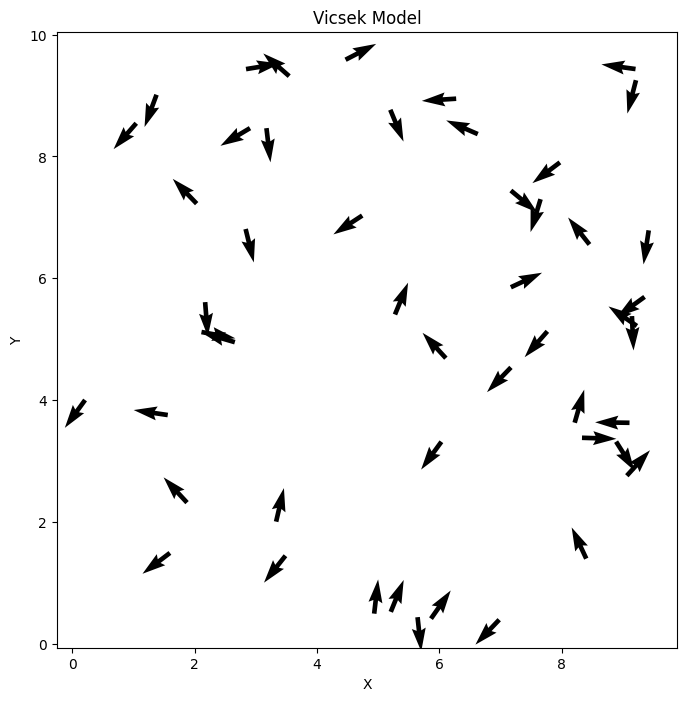

In [230]:
a = animate(trajectories, headings, num_timesteps=50)

In [231]:
HTML(a.to_jshtml())

### Hyperpriors and Conditional Priors

Hyperpriors:

\begin{align}
    \alpha_j, \beta_j   &\sim \mathrm{Gamma}(2, 2), \\
    \varrho_j           &\sim \mathrm{Gamma}(2, 1), \\
    \mu_j               &\sim \mathcal{U}(0, \pi).
\end{align}

Conditional priors: 

\begin{align}
    r     &\sim \mathrm{Gamma}(\varrho_j, 1), \\
    v     &\sim \mathrm{Gamma}(\alpha_j, \beta_j), \\
    \eta_j  &\sim \mathcal{U}(0, \mu_j).
\end{align}

$\eta_j$ is not considered a hyperprior on its own, due to the fact that each agent would theoretically have a different degree of noise magnitude (further sampled from $\mu_j$, which is the hyperprior for $\eta_j$.)

In [468]:
def hyperprior_fun(rng=None):
    if rng is None:
        rng = np.random.default_rng()

    # Hyperpriors
    alpha_j = rng.gamma(2,2)
    beta_j = rng.gamma(2,2)
    rho_j = rng.gamma(2,1)
    mu_j = rng.uniform(0, np.pi)

    return alpha_j, beta_j, rho_j, mu_j

In [479]:
def prior_fun(hyperpriors=None, rng=None):

    if rng is None:
        rng = np.random.default_rng()

    def hyperprior_fun(rng=rng):
        # Hyperpriors
        alpha_j = rng.gamma(2,2)
        beta_j = rng.gamma(2,2)
        rho_j = rng.gamma(2,1)
        mu_j = rng.uniform(0, np.pi)

        return alpha_j, beta_j, rho_j, mu_j
    
    if hyperpriors is not None:
        alpha_j, beta_j, rho_j, mu_j = hyperpriors
    else:
        alpha_j, beta_j, rho_j, mu_j = hyperprior_fun()

    # Conditional priors
    r = rng.gamma(rho_j, 1)
    v = rng.gamma(alpha_j, beta_j)
    eta = rng.uniform(0, mu_j)

    return np.array([r, v, eta, alpha_j, beta_j, rho_j, mu_j])

In [480]:
test_prior = prior_fun()
test_prior

array([ 0.61547903, 34.89046148,  0.28563166,  8.0778232 ,  3.78019668,
        2.10170067,  1.79832446])

In [472]:
test_simulator = simulator_fun(theta=test_prior, num_agents=24)
test_simulator.shape

(101, 24, 3)

In [487]:
prior = bf.simulation.Prior(prior_fun=prior_fun, param_names=PARAM_NAMES)
prior(batch_size=1)

{'prior_draws': array([[1.17525639, 6.63192648, 0.18987443, 2.06555577, 4.69869493,
         1.28640418, 1.38975539]]),
 'batchable_context': None,
 'non_batchable_context': None}

### Prior Predictive Checks

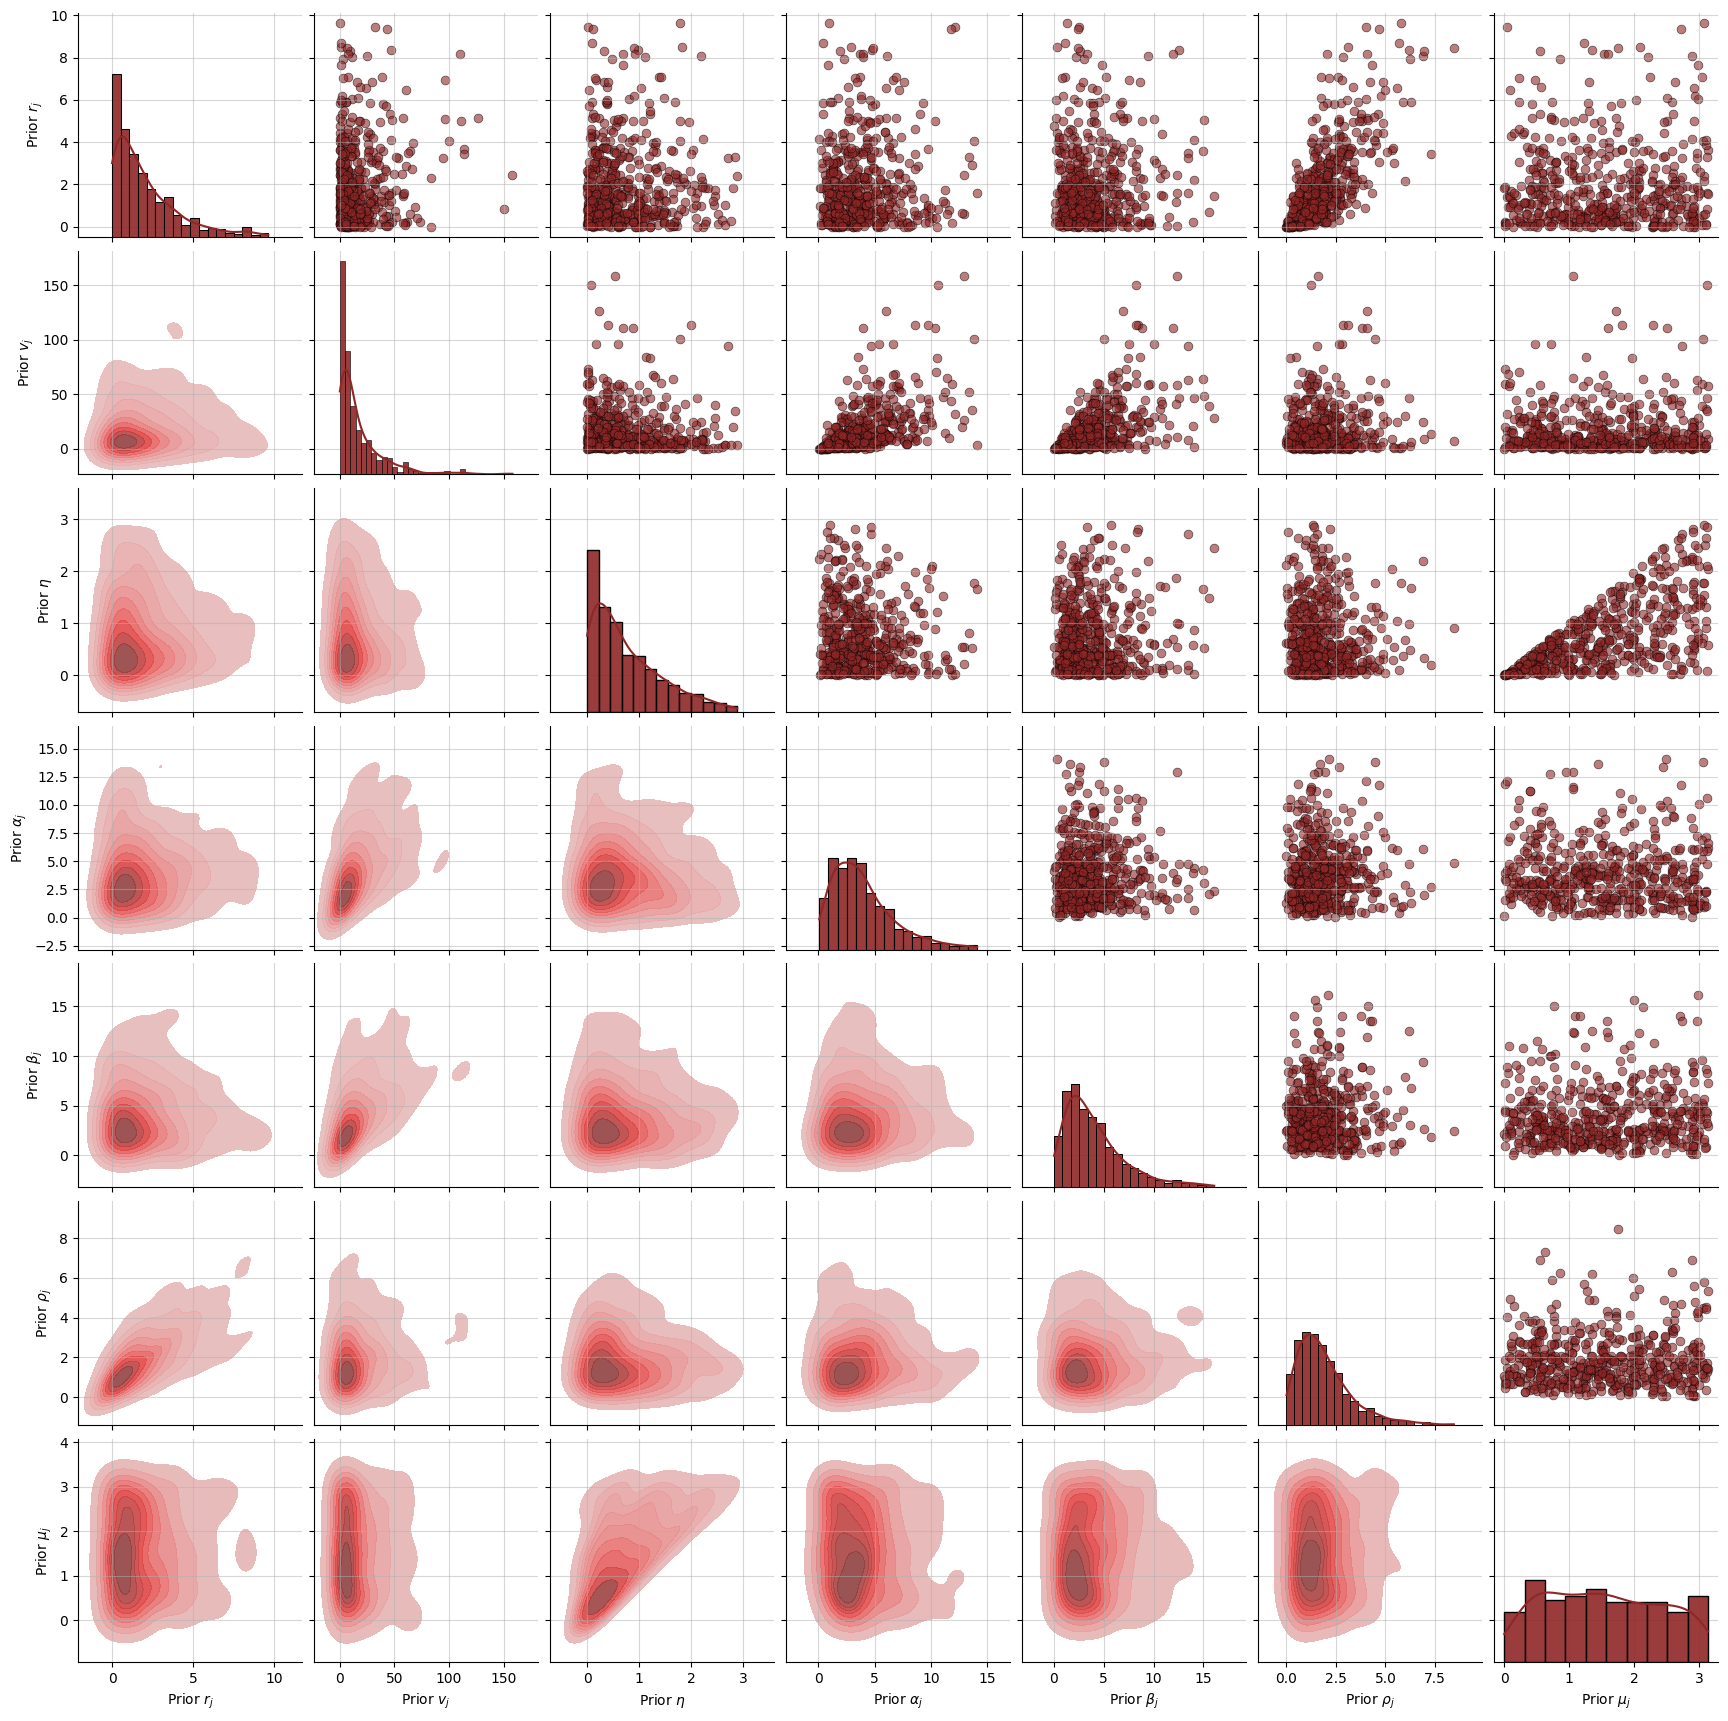

In [488]:
f = prior.plot_prior2d(n_samples=500)

In [518]:
simulator = bf.simulation.Simulator(
    simulator_fun=partial(simulator_fun, num_timesteps=200, num_agents=12)
)

In [519]:
model = bf.simulation.GenerativeModel(
    prior=prior, simulator=simulator, simulator_is_batched=False
)

INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 7)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 201, 12, 3)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


Making sure that the model works.

In [491]:
test_sim = model(5)
test_sim['sim_data'].shape

(5, 201, 12, 3)

In [448]:
time_stamps = np.linspace(0, 1, test_sim['sim_data'].shape[1])
time_stamps = np.tile(time_stamps[np.newaxis, :, np.newaxis, np.newaxis], (5, 1, 49, 1))
time_stamps.shape

(5, 202, 49, 1)

### Data Configuration and Time-Embedding

In [402]:
def configurator(input_dict):
    output_dict = {}

    theta = input_dict['prior_draws']
    output_dict['parameters'] = theta

    x = input_dict['sim_data']

    # add time encoding to the data x
    batch_size, num_timesteps, num_agents, _ = x.shape
    time_encoding = np.linspace(0, 1, num_timesteps)
    time_encoding_batched = np.tile(
        time_encoding[np.newaxis, :, np.newaxis, np.newaxis], 
        (batch_size, 1, num_agents, 1)
    )

    output_dict['summary_conditions'] = np.concatenate((x, time_encoding_batched), axis=-1)

    return output_dict

In [492]:
out = configurator(test_sim)
out['summary_conditions'].shape

(5, 201, 12, 4)

In [493]:
x = out['summary_conditions']
x[0, :, 1, -1]

array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
       0.045, 0.05 , 0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085,
       0.09 , 0.095, 0.1  , 0.105, 0.11 , 0.115, 0.12 , 0.125, 0.13 ,
       0.135, 0.14 , 0.145, 0.15 , 0.155, 0.16 , 0.165, 0.17 , 0.175,
       0.18 , 0.185, 0.19 , 0.195, 0.2  , 0.205, 0.21 , 0.215, 0.22 ,
       0.225, 0.23 , 0.235, 0.24 , 0.245, 0.25 , 0.255, 0.26 , 0.265,
       0.27 , 0.275, 0.28 , 0.285, 0.29 , 0.295, 0.3  , 0.305, 0.31 ,
       0.315, 0.32 , 0.325, 0.33 , 0.335, 0.34 , 0.345, 0.35 , 0.355,
       0.36 , 0.365, 0.37 , 0.375, 0.38 , 0.385, 0.39 , 0.395, 0.4  ,
       0.405, 0.41 , 0.415, 0.42 , 0.425, 0.43 , 0.435, 0.44 , 0.445,
       0.45 , 0.455, 0.46 , 0.465, 0.47 , 0.475, 0.48 , 0.485, 0.49 ,
       0.495, 0.5  , 0.505, 0.51 , 0.515, 0.52 , 0.525, 0.53 , 0.535,
       0.54 , 0.545, 0.55 , 0.555, 0.56 , 0.565, 0.57 , 0.575, 0.58 ,
       0.585, 0.59 , 0.595, 0.6  , 0.605, 0.61 , 0.615, 0.62 , 0.625,
       0.63 , 0.635,

### Neural Approximator

Currently, it has to be assumed that all data within the timeseries for each agent are considered i.i.d., and therefore, `DeepSet` is used instead of `TimeSeriesTransformer`. It does seem that `TimeSeriesTransformer` is not compatible with `HierarchicalNetwork`. This is something that I will develop into BayesFlow in the future, once I get to know more about how things work between each other.

In [494]:
# This is incorrect, because it assumes i.i.d for timeseries. But I have to use it for now.
summary_net = bf.summary_networks.HierarchicalNetwork([
    bf.networks.DeepSet(),
    bf.networks.DeepSet(summary_dim=64)
])

In [498]:
inference_net = bf.inference_networks.InvertibleNetwork(
    num_params=7, 
    num_coupling_layers=6,
    coupling_settings={
        'kernel_regularizer': tf.keras.regularizers.l2(1e-4),
        'dropout_prob': 0.10
    }
)

In [499]:
amortizer = bf.amortizers.AmortizedPosterior(inference_net=inference_net, summary_net=summary_net)

## Training

In [500]:
trainer = bf.trainers.Trainer(
    generative_model=model,
    amortizer=amortizer,
    configurator=configurator
)

INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


In [501]:
amortizer.summary()

Model: "amortized_posterior_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 invertible_network_7 (Inve  multiple                  617724    
 rtibleNetwork)                                                  
                                                                 
 hierarchical_network_8 (Hi  multiple                  139722    
 erarchicalNetwork)                                              
                                                                 
Total params: 757446 (2.89 MB)
Trainable params: 757362 (2.89 MB)
Non-trainable params: 84 (336.00 Byte)
_________________________________________________________________


In [502]:
simulation = model(500)

In [503]:
losses = trainer.train_offline(simulation, epochs=100, batch_size=16, validation_sims=model(200))

Training epoch 1:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1, Loss: 15.513


Training epoch 2:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 2, Loss: 14.512


Training epoch 3:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 3, Loss: 13.709


Training epoch 4:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 4, Loss: 13.950


Training epoch 5:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 5, Loss: 13.338


Training epoch 6:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 6, Loss: 13.240


Training epoch 7:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 7, Loss: 13.150


Training epoch 8:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 8, Loss: 13.108


Training epoch 9:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 9, Loss: 12.955


Training epoch 10:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 10, Loss: 12.806


Training epoch 11:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 11, Loss: 13.060


Training epoch 12:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 12, Loss: 12.817


Training epoch 13:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 13, Loss: 12.871


Training epoch 14:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 14, Loss: 12.652


Training epoch 15:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 15, Loss: 12.541


Training epoch 16:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 16, Loss: 12.437


Training epoch 17:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 17, Loss: 12.295


Training epoch 18:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 18, Loss: 11.915


Training epoch 19:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 19, Loss: 11.893


Training epoch 20:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 20, Loss: 11.911


Training epoch 21:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 21, Loss: 11.978


Training epoch 22:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 22, Loss: 11.698


Training epoch 23:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 23, Loss: 12.047


Training epoch 24:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 24, Loss: 11.851


Training epoch 25:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 25, Loss: 11.636


Training epoch 26:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 26, Loss: 11.720


Training epoch 27:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 27, Loss: 11.765


Training epoch 28:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 28, Loss: 11.819


Training epoch 29:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 29, Loss: 11.709


Training epoch 30:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 30, Loss: 12.010


Training epoch 31:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 31, Loss: 11.593


Training epoch 32:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 32, Loss: 11.839


Training epoch 33:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 33, Loss: 11.746


Training epoch 34:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 34, Loss: 11.910


Training epoch 35:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 35, Loss: 11.698


Training epoch 36:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 36, Loss: 12.206


Training epoch 37:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 37, Loss: 12.202


Training epoch 38:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 38, Loss: 12.343


Training epoch 39:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 39, Loss: 11.666


Training epoch 40:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 40, Loss: 12.080


Training epoch 41:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 41, Loss: 12.635


Training epoch 42:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 42, Loss: 12.063


Training epoch 43:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 43, Loss: 11.919


Training epoch 44:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 44, Loss: 12.656


Training epoch 45:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 45, Loss: 12.064


Training epoch 46:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 46, Loss: 12.316


Training epoch 47:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 47, Loss: 12.470


Training epoch 48:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 48, Loss: 14.268


Training epoch 49:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 49, Loss: 12.041


Training epoch 50:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 50, Loss: 13.086


Training epoch 51:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 51, Loss: 13.066


Training epoch 52:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 52, Loss: 12.317


Training epoch 53:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 53, Loss: 12.272


Training epoch 54:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 54, Loss: 12.330


Training epoch 55:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 55, Loss: 13.030


Training epoch 56:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 56, Loss: 12.539


Training epoch 57:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 57, Loss: 12.844


Training epoch 58:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 58, Loss: 12.787


Training epoch 59:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 59, Loss: 12.443


Training epoch 60:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 60, Loss: 12.907


Training epoch 61:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 61, Loss: 13.091


Training epoch 62:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 62, Loss: 12.361


Training epoch 63:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 63, Loss: 12.743


Training epoch 64:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 64, Loss: 13.962


Training epoch 65:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 65, Loss: 13.395


Training epoch 66:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 66, Loss: 13.070


Training epoch 67:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 67, Loss: 12.964


Training epoch 68:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 68, Loss: 13.911


Training epoch 69:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 69, Loss: 13.070


Training epoch 70:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 70, Loss: 13.918


Training epoch 71:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 71, Loss: 13.812


Training epoch 72:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 72, Loss: 14.154


Training epoch 73:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 73, Loss: 13.777


Training epoch 74:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 74, Loss: 14.294


Training epoch 75:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 75, Loss: 13.931


Training epoch 76:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 76, Loss: 13.680


Training epoch 77:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 77, Loss: 13.625


Training epoch 78:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 78, Loss: 14.412


Training epoch 79:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 79, Loss: 13.859


Training epoch 80:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 80, Loss: 14.329


Training epoch 81:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 81, Loss: 14.003


Training epoch 82:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 82, Loss: 13.960


Training epoch 83:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 83, Loss: 14.094


Training epoch 84:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 84, Loss: 14.082


Training epoch 85:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 85, Loss: 13.937


Training epoch 86:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 86, Loss: 14.545


Training epoch 87:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 87, Loss: 14.103


Training epoch 88:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 88, Loss: 14.334


Training epoch 89:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 89, Loss: 14.482


Training epoch 90:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 90, Loss: 14.402


Training epoch 91:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 91, Loss: 14.506


Training epoch 92:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 92, Loss: 14.546


Training epoch 93:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 93, Loss: 14.645


Training epoch 94:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 94, Loss: 14.510


Training epoch 95:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 95, Loss: 14.438


Training epoch 96:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 96, Loss: 14.419


Training epoch 97:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 97, Loss: 14.449


Training epoch 98:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 98, Loss: 14.429


Training epoch 99:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 99, Loss: 14.433


Training epoch 100:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 100, Loss: 14.434


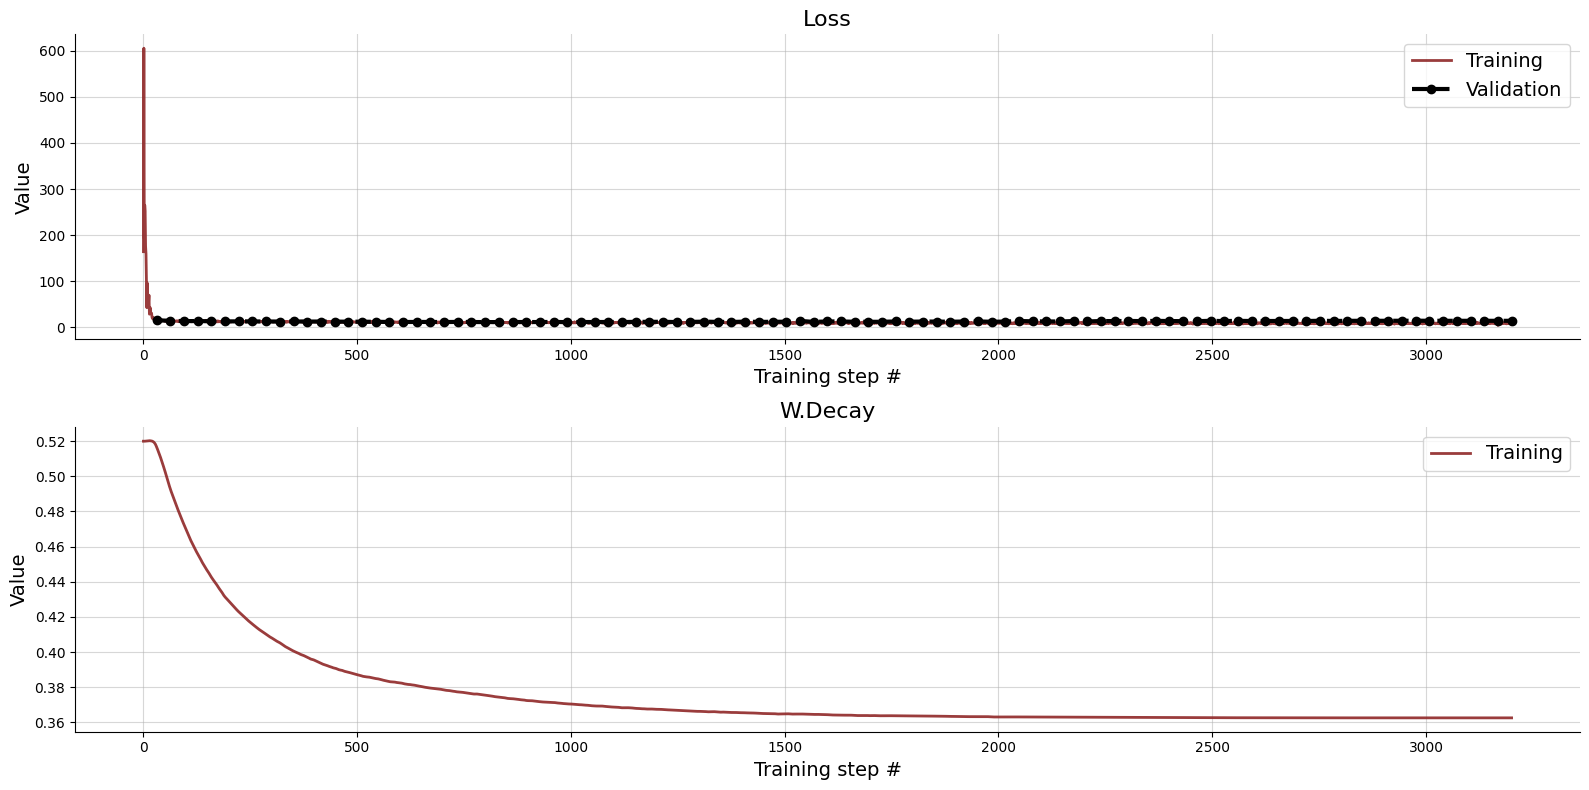

In [504]:
f = bf.diagnostics.plot_losses(losses['train_losses'], losses['val_losses'])

## Validation

In [527]:
validation_sim = model(200)

In [528]:
validation_sim = configurator(validation_sim)

In [529]:
post_samples = amortizer.sample(validation_sim, n_samples=1000)
post_samples.shape

(200, 1000, 7)

In [530]:
prior_means, prior_stds = prior.estimate_means_and_stds(n_draws=10000)
prior_stds

array([[ 2.00465265, 21.27653581,  0.69156426,  2.88641171,  2.85386891,
         1.41772387,  0.90636417]])

In [531]:
prior_samples = validation_sim["parameters"] * prior_stds + prior_means

Parameter Recovery

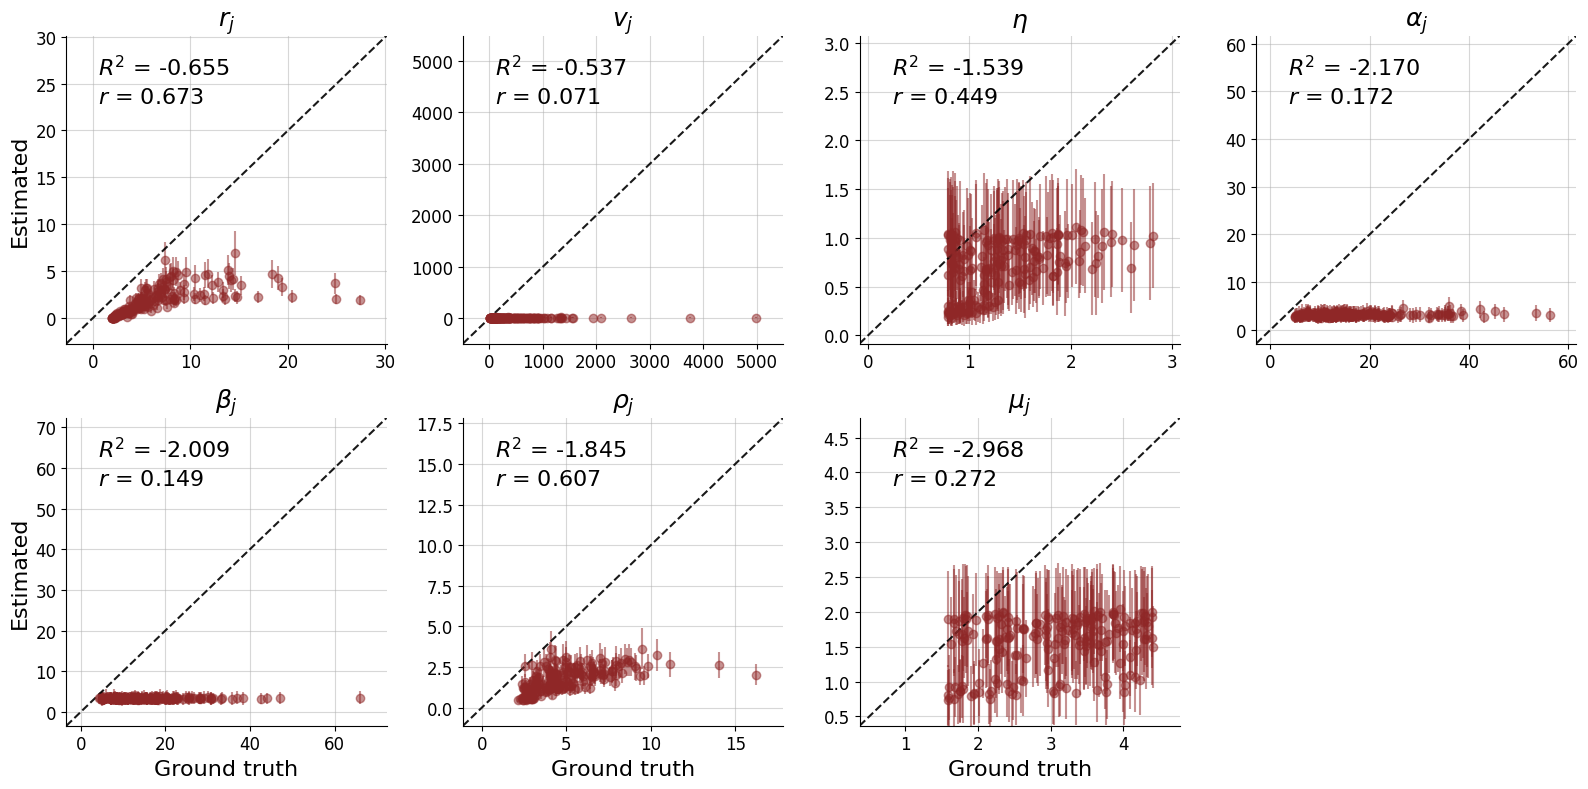

In [532]:
f = bf.diagnostics.plot_recovery(post_samples=post_samples, prior_samples=prior_samples, param_names=PARAM_NAMES)

Possible reason: not using `TimeSeriesTransformer`.

Simulation-based calibration

INFO:root:The ratio of simulations / posterior draws should be > 20 for reliable variance reduction, but your ratio is 0.                    Confidence intervals might be unreliable!


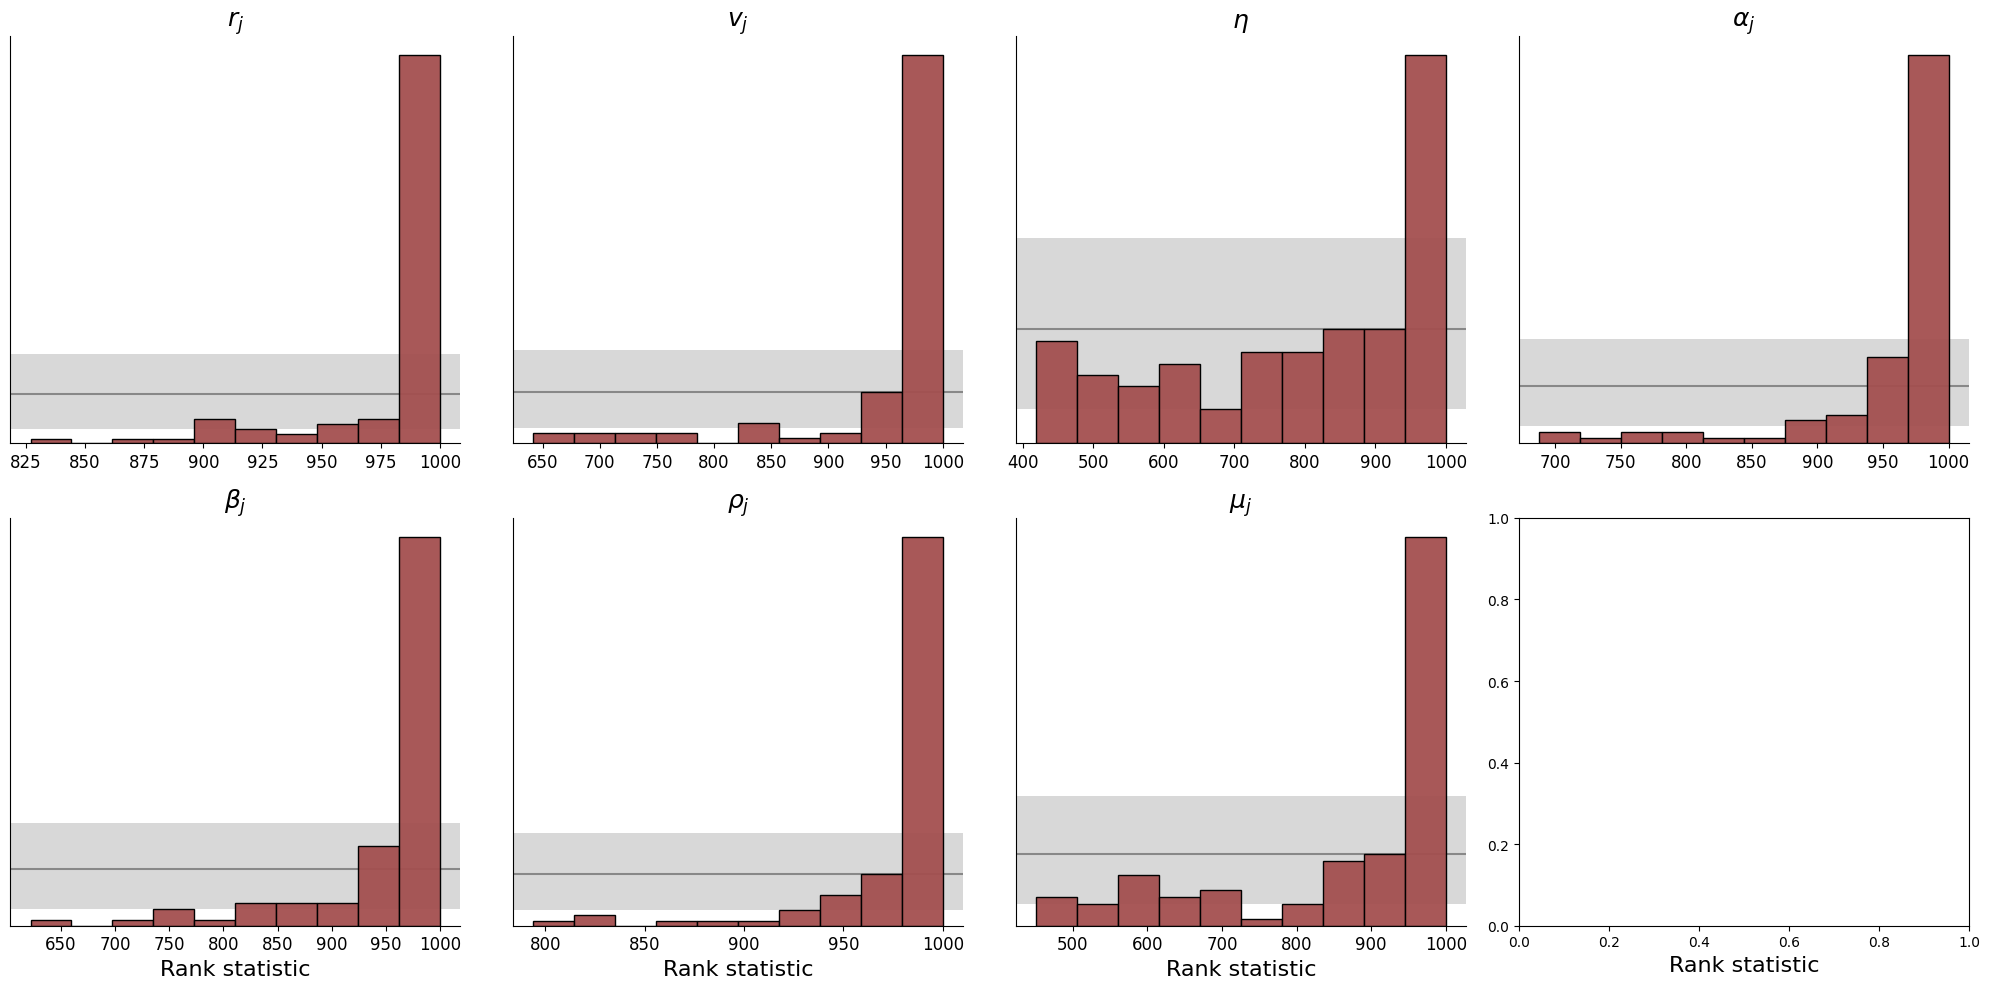

In [526]:
f = bf.diagnostics.plot_sbc_histograms(post_samples=post_samples, prior_samples=prior_samples, param_names=PARAM_NAMES, num_bins=10)

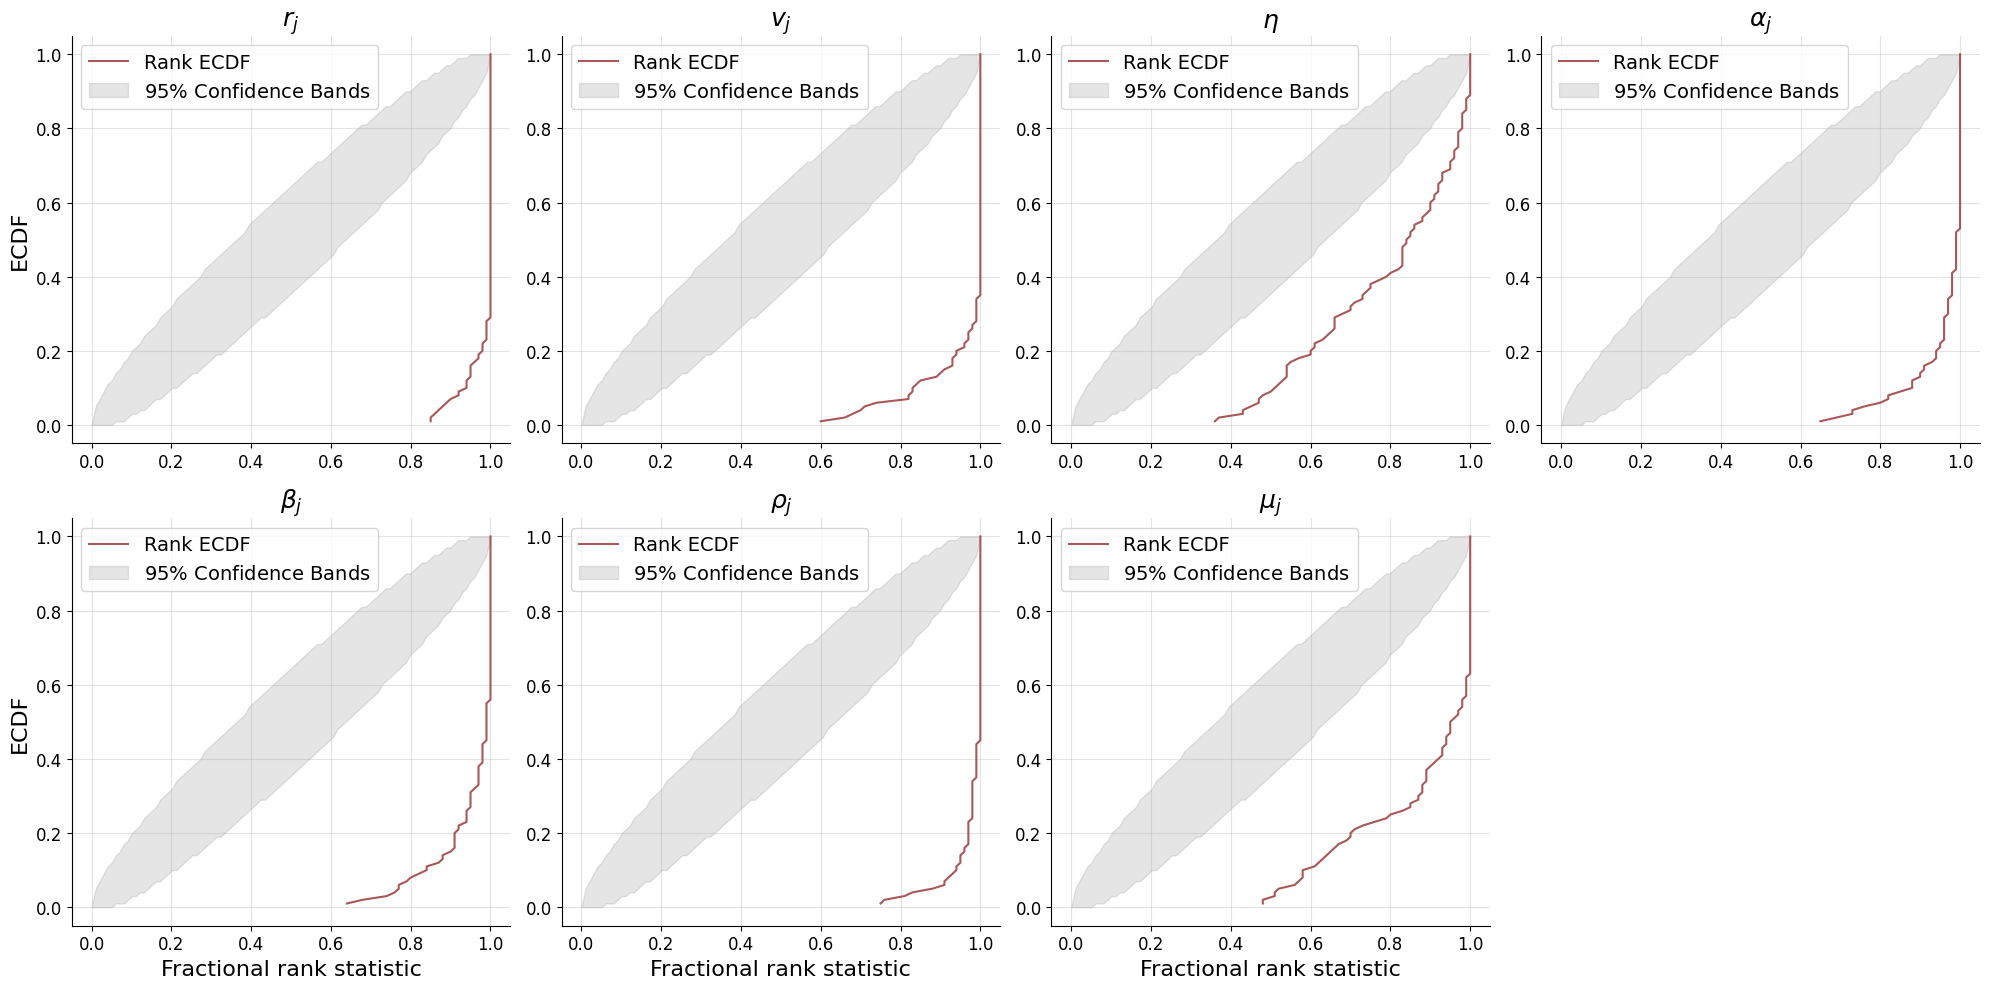

In [512]:
f = bf.diagnostics.plot_sbc_ecdf(post_samples=post_samples, prior_samples=prior_samples, param_names=PARAM_NAMES)

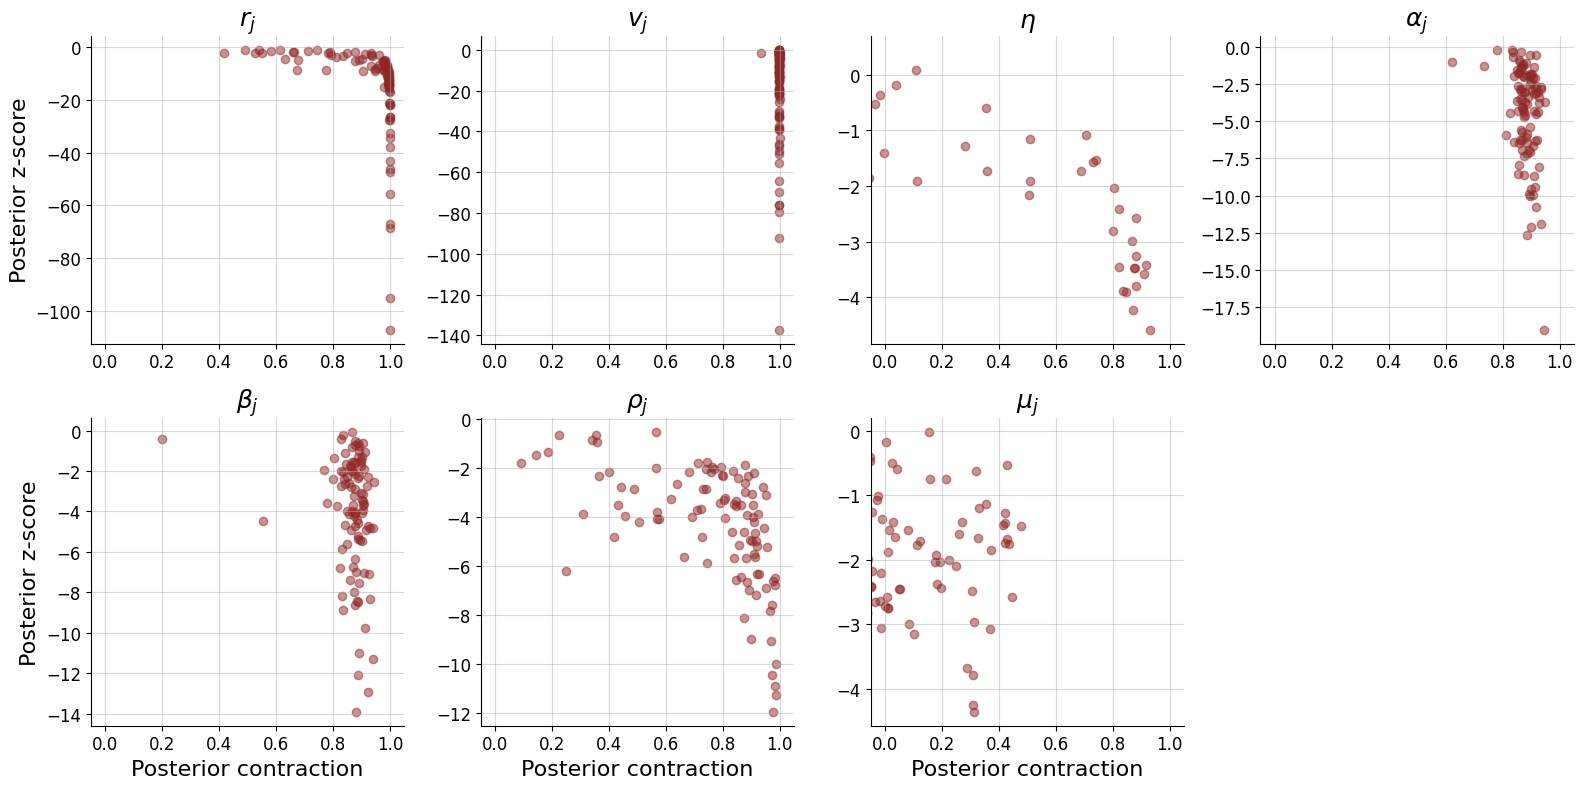

In [513]:
f = bf.diagnostics.plot_z_score_contraction(post_samples=post_samples, prior_samples=prior_samples, param_names=PARAM_NAMES)

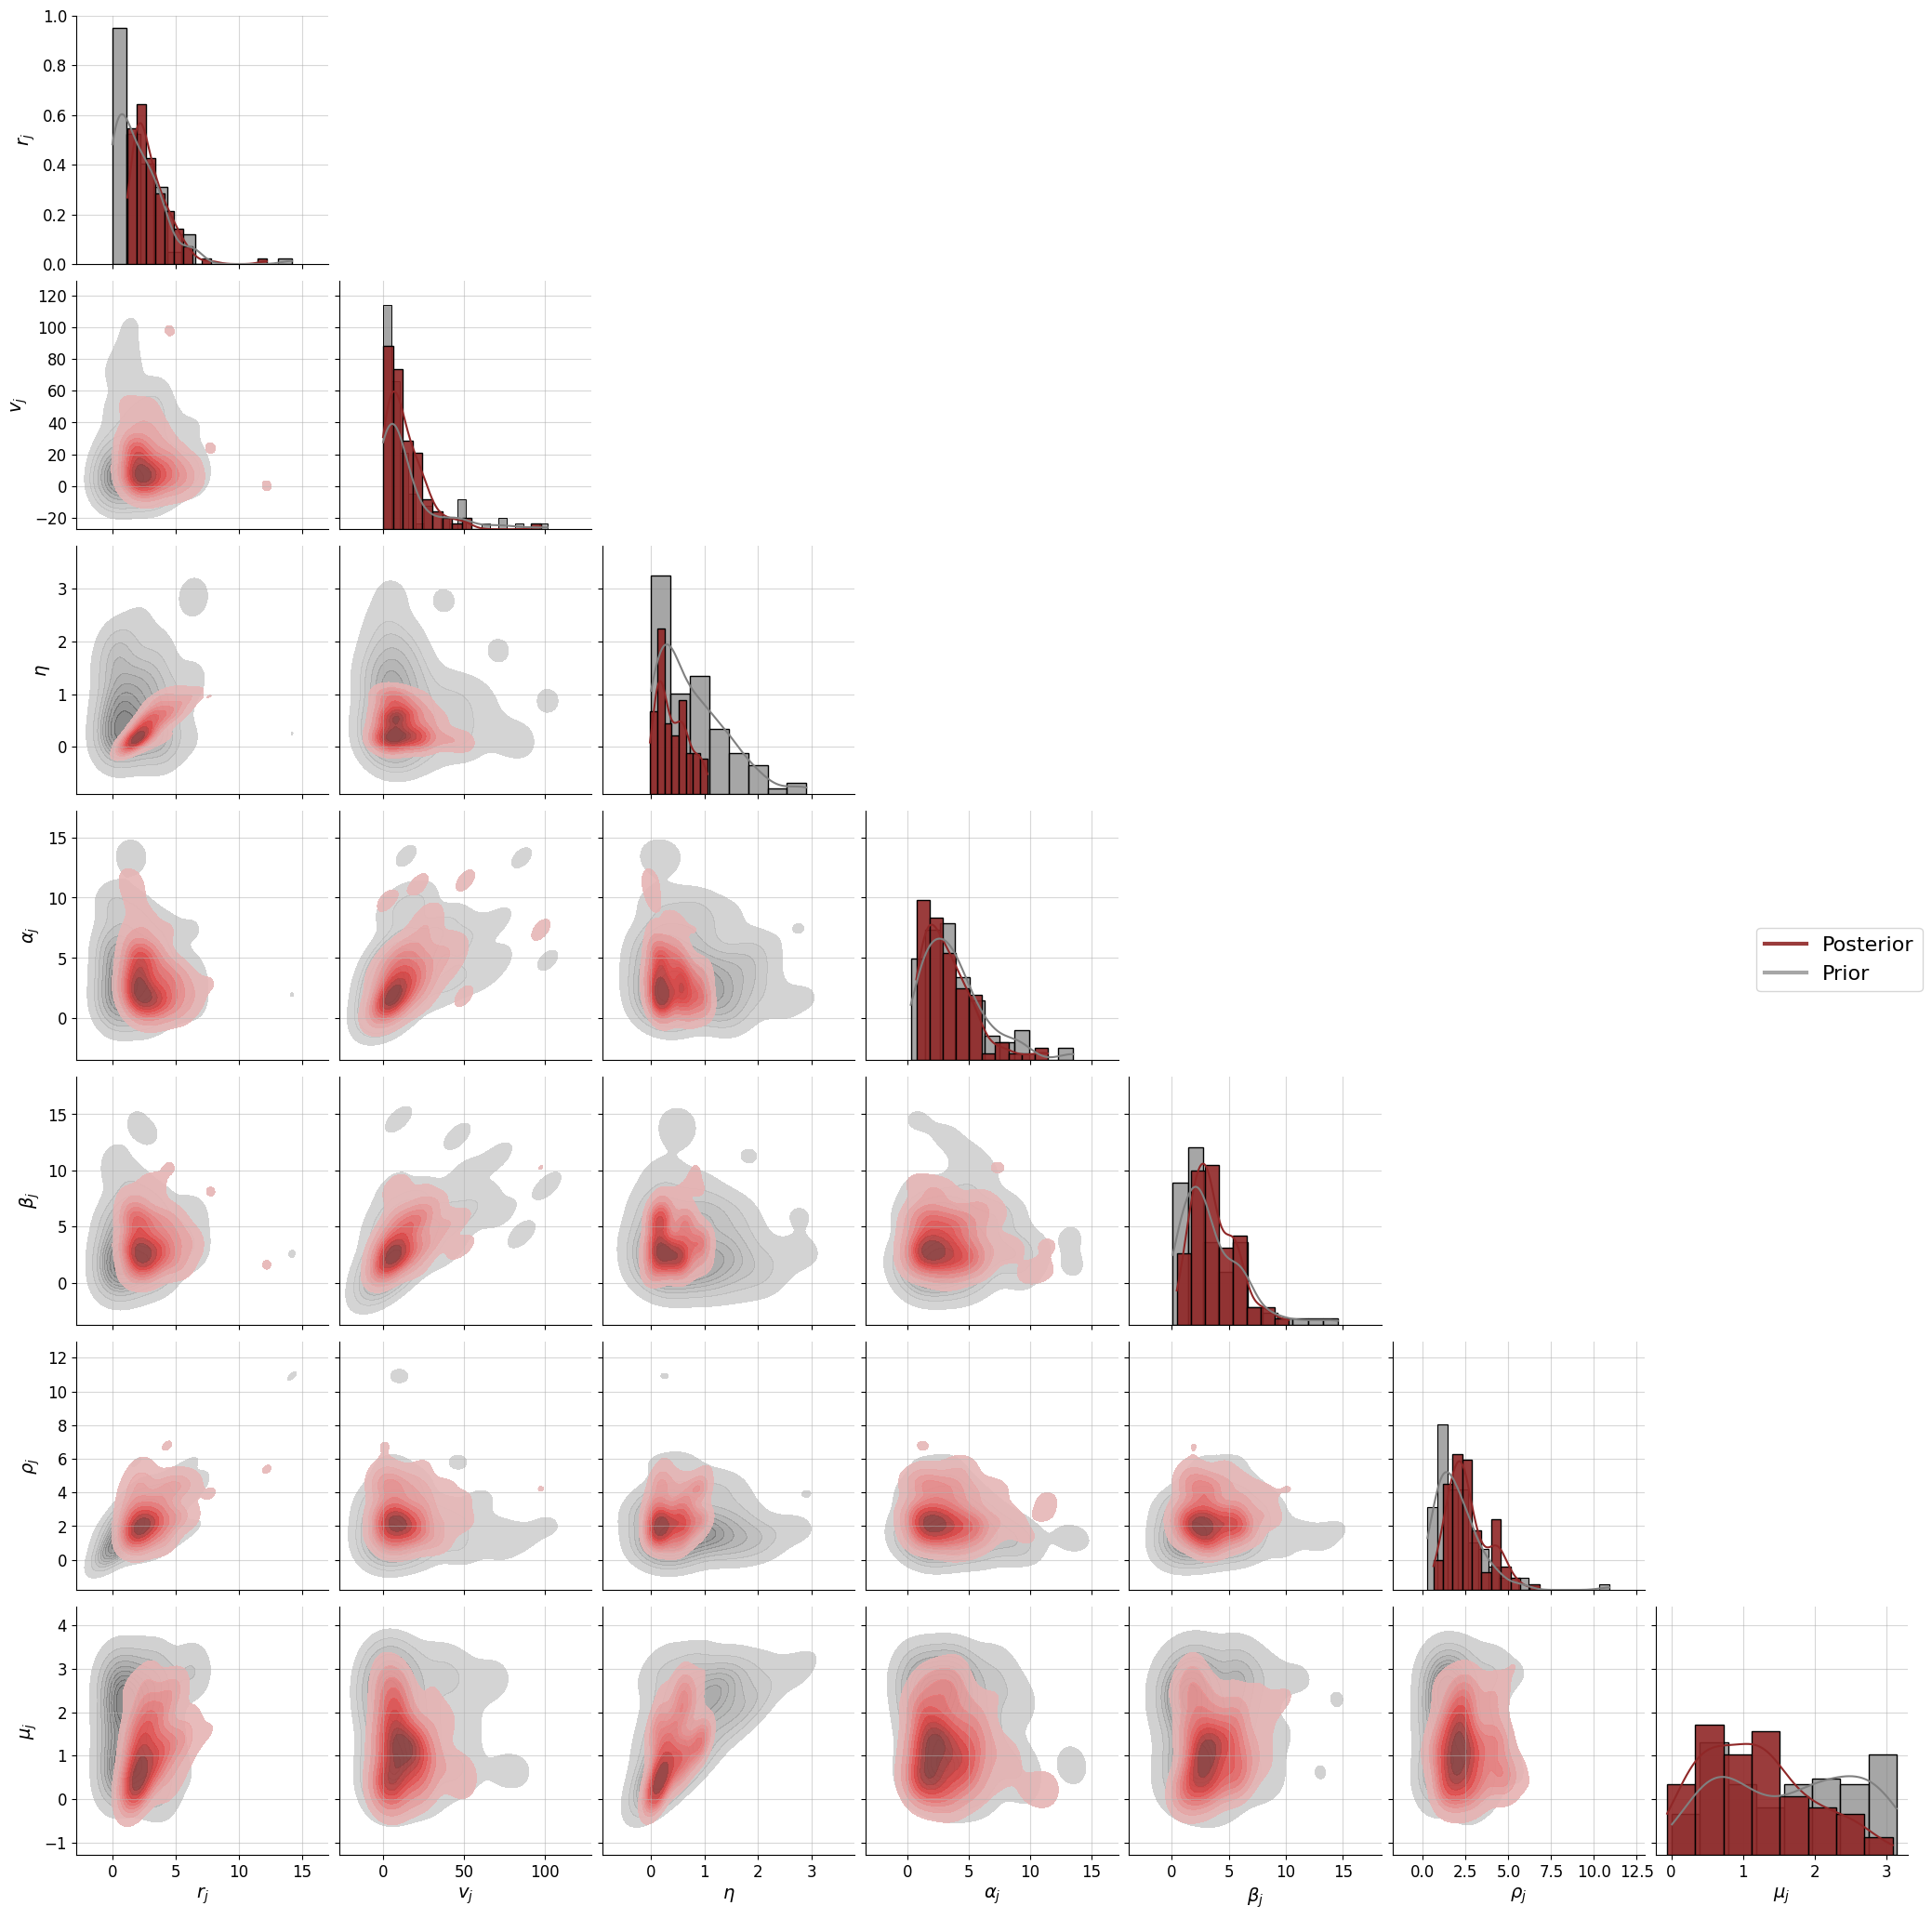

In [514]:
f = bf.diagnostics.plot_posterior_2d(posterior_draws=post_samples[0], prior=prior, param_names=PARAM_NAMES)